# --- 1. INSTALACIÓN Y CONFIGURACIÓN ---



In [1]:

!pip install ortools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import copy
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# Configurar dispositivo (GPU si está disponible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo: {DEVICE}")

# Crear carpetas para organizar archivos
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
    

✅ Usando dispositivo: cuda
✅ Usando dispositivo: cuda


# --- 2. CLASES AUXILIARES Y SOLVER ---

In [2]:
class TSP_Instance:
    def __init__(self, city_locations):
        self.city_locations = city_locations
        self.num_cities = len(city_locations)
        # Matriz de distancias Euclidianas
        diff = city_locations[:, np.newaxis, :] - city_locations[np.newaxis, :, :]
        self.distance_matrix = np.sqrt(np.sum(diff ** 2, axis=-1))

class TSP_State:
    def __init__(self, instance):
        self.instance = instance
        self.num_cities = instance.num_cities
        self.visited = [False] * self.num_cities
        self.current_city = 0
        self.tour = [0] # Siempre empezamos en 0
        self.visited[0] = True
        self.cost = 0.0

    def visit_city(self, city_idx):
        if not self.visited[city_idx]:
            dist = self.instance.distance_matrix[self.current_city][city_idx]
            self.cost += dist
            self.current_city = city_idx
            self.tour.append(city_idx)
            self.visited[city_idx] = True

    def is_finished(self):
        return all(self.visited)

    def plot(self):
        x = [self.instance.city_locations[i][0] for i in self.tour]
        y = [self.instance.city_locations[i][1] for i in self.tour]
        if self.is_finished(): # Cerrar el ciclo
            x.append(x[0])
            y.append(y[0])
        plt.figure(figsize=(5, 5))
        plt.scatter(x, y, c='red')
        plt.plot(x, y, c='blue')
        plt.title(f"Costo: {self.cost:.4f}")
        plt.show()

def solve_ortools(instance):
    # Configurar datos para OR-Tools
    scale = 10000
    dist_matrix = (instance.distance_matrix * scale).astype(int).tolist()

    manager = pywrapcp.RoutingIndexManager(instance.num_cities, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return dist_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)

    # Extraer tour
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
    return route # Retorna lista de índices

# --- 3. GENERACIÓN DE DATOS ---

In [ ]:
# ==========================================
# EXTENSIÓN DE DATASET EN DRIVE
# ==========================================
import pickle
import os
import numpy as np
import shutil
from google.colab import drive

def extend_dataset_in_drive(extra_samples=10000, num_cities=35, drive_folder="TSP", filename="TSP50_train.pkl"):
    # 1. Montar Drive
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

    drive_path = f"/content/drive/MyDrive/{drive_folder}/{filename}"
    local_path = filename

    # 2. Cargar datos existentes si existen
    X_existing, Visited_existing, Y_existing = [], [], []

    if os.path.exists(drive_path):
        print(f"📂 Archivo encontrado. Cargando datos actuales de {filename}...")
        with open(drive_path, "rb") as f:
            X_existing, Visited_existing, Y_existing = pickle.load(f)

        # Convertir a listas para poder hacer .append fácilmente
        X_existing = list(X_existing)
        Visited_existing = list(Visited_existing)
        Y_existing = list(Y_existing)
        print(f"   Ejemplos actuales: {len(X_existing)}")
    else:
        print("⚠️ No se encontró el archivo previo. Se creará uno nuevo.")

    # 3. Generar nuevos datos (Lógica igual a tu Bloque 3)
    print(f"🚀 Generando {extra_samples} nuevas instancias...")

    for i in range(extra_samples):
        locs = np.random.rand(num_cities, 2)
        instance = TSP_Instance(locs)
        optimal_tour = solve_ortools(instance)

        current_state_tour = [0]

        # Simulamos pasos del tour
        for target_city in optimal_tour[1:]:
            X_existing.append(locs)

            vis_pad = np.array(current_state_tour)
            vis_pad = np.pad(vis_pad, (0, num_cities - len(vis_pad)), 'constant', constant_values=-1)
            Visited_existing.append(vis_pad)

            y_onehot = np.zeros(num_cities)
            y_onehot[target_city] = 1
            Y_existing.append(y_onehot)

            current_state_tour.append(target_city)

        if (i + 1) % 1000 == 0:
            print(f"   ✅ {i + 1}/{extra_samples} mapas procesados...")

    # 4. Guardar archivo actualizado
    print(f"💾 Guardando dataset actualizado (Total: {len(X_existing)} ejemplos)...")
    updated_data = (np.array(X_existing), np.array(Visited_existing), np.array(Y_existing))

    # Guardar localmente primero (por seguridad)
    with open(local_path, "wb") as f:
        pickle.dump(updated_data, f)

    # Mover a Drive reemplazando el viejo
    shutil.copy(local_path, drive_path)

    print(f"✨ ¡Listo! Tu archivo en Drive '{drive_path}' ha sido actualizado.")

# EJECUTAR
extend_dataset_in_drive(extra_samples=10000, num_cities=35)

🔄 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Archivo encontrado. Cargando datos actuales de TSP50_train.pkl...
   Ejemplos actuales: 680000
🚀 Generando 10000 nuevas instancias...
   ✅ 1000/10000 mapas procesados...
   ✅ 2000/10000 mapas procesados...
   ✅ 3000/10000 mapas procesados...
   ✅ 4000/10000 mapas procesados...
   ✅ 5000/10000 mapas procesados...
   ✅ 6000/10000 mapas procesados...
   ✅ 7000/10000 mapas procesados...
   ✅ 8000/10000 mapas procesados...
   ✅ 9000/10000 mapas procesados...
   ✅ 10000/10000 mapas procesados...
💾 Guardando dataset actualizado (Total: 1020000 ejemplos)...
✨ ¡Listo! Tu archivo en Drive '/content/drive/MyDrive/TSP/TSP50_train.pkl' ha sido actualizado.


# --- 4. ARQUITECTURA DEL MODELO ---

In [3]:
class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hyperparams = kwargs

    def encode(self, x): raise NotImplementedError
    def decode(self, mem, vis): raise NotImplementedError

class TSPTransformer(Transformer):
    def __init__(self, input_dim=2, embed_dim=128, num_heads=8, num_encoder_layers=2,
                 num_glimpses=2, dropout_rate=0.1, dist_bias_scale=1.0):
        super().__init__(input_dim=input_dim, embed_dim=embed_dim, num_heads=num_heads,
                         num_encoder_layers=num_encoder_layers, num_glimpses=num_glimpses,
                         dropout_rate=dropout_rate, dist_bias_scale=dist_bias_scale)

        self.embed_dim = embed_dim
        self.dist_bias_scale = dist_bias_scale
        self.num_glimpses = num_glimpses

        # Encoder
        self.encoder_input_layer = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dropout=dropout_rate, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder Components
        self.ctx_fusion = nn.Linear(3 * embed_dim, embed_dim)
        self.glimpse_proj = nn.Linear(embed_dim, embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout_rate, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(nn.Linear(embed_dim, 4*embed_dim), nn.ReLU(), nn.Linear(4*embed_dim, embed_dim))
        self.norm2 = nn.LayerNorm(embed_dim)
        self.pointer_proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def encode(self, x_src):
        # x_src: [B, N, 2]
        return self.encoder(self.encoder_input_layer(x_src))

    def decode(self, memory, coords, visited):
        # memory: [B, N, E], coords: [B, N, 2], visited: [B, T] (padded with -1)
        B, N, _ = memory.shape
        device = memory.device

        # Máscaras
        visited_mask_pos = (visited != -1)
        visited_city_mask = torch.zeros(B, N, dtype=torch.bool, device=device)

        # Scatter para marcar ciudades visitadas
        # Truco para manejar el batch
        batch_indices = torch.arange(B, device=device).unsqueeze(1).expand_as(visited)
        valid_visited = visited.clone()
        valid_visited[~visited_mask_pos] = 0 # Evitar error de índice, luego se ignoran
        visited_city_mask[batch_indices[visited_mask_pos], valid_visited[visited_mask_pos].long()] = True

        # Contexto
        mask_expanded = visited_city_mask.unsqueeze(-1).float()
        sum_ctx = (memory * mask_expanded).sum(dim=1)
        count_ctx = mask_expanded.sum(dim=1).clamp(min=1)
        context_mean = sum_ctx / count_ctx

        # Start & Last Node
        # Ultimo válido:
        lengths = visited_mask_pos.sum(dim=1) - 1
        last_nodes = visited.gather(1, lengths.unsqueeze(1)).squeeze(1).long()
        start_nodes = visited[:, 0].long() # Siempre el primero

        batch_idx = torch.arange(B, device=device)
        start_embed = memory[batch_idx, start_nodes]
        last_embed = memory[batch_idx, last_nodes]

        # Fusión
        ctx_concat = torch.cat([context_mean, last_embed, start_embed], dim=-1)
        decoder_state = self.ctx_fusion(ctx_concat)

        # Glimpses
        query = self.glimpse_proj(decoder_state).unsqueeze(1) # [B, 1, E]

        for _ in range(self.num_glimpses):
            attn_out, _ = self.cross_attn(query, memory, memory, key_padding_mask=visited_city_mask)
            query = self.norm1(attn_out + query)
            ff_out = self.ff(query)
            query = self.norm2(ff_out + query)

        attn_out = query.squeeze(1)

        # Pointer & Scores
        ptr_query = self.pointer_proj(attn_out).unsqueeze(1)
        scores = torch.matmul(ptr_query, memory.transpose(1, 2)).squeeze(1)
        scores = scores / math.sqrt(self.embed_dim)

        # Distance Bias
        last_city_coords = coords[batch_idx, last_nodes] # [B, 2]
        dists = torch.norm(coords - last_city_coords.unsqueeze(1), dim=-1) # [B, N]
        scores = scores - (self.dist_bias_scale * dists)

        # Masking final
        scores = scores.masked_fill(visited_city_mask, float('-inf'))
        return scores # Devolvemos logits para CrossEntropyLoss

    def forward(self, x_src, visited):
        memory = self.encode(x_src)
        return self.decode(memory, x_src, visited)

# --- 5. ENTRENAMIENTO ---

In [ ]:
# --- 5. ENTRENAMIENTO CON DATA AUGMENTATION (Rotación) ---
from google.colab import drive
import shutil
import os
import pickle
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# --- NUEVA FUNCIÓN DE AUMENTO DE DATOS ---
def augment_dataset_rotation(X, Visited, Y):
    """
    Multiplica el dataset x4 aplicando rotaciones de 90, 180 y 270 grados.
    Asume que X está en el rango [0, 1].
    """
    print(f"✨ Aplicando Data Augmentation (Rotación)... Tamaño original: {len(X)}")

    # 1. Original (0°)
    X_0 = X.clone()

    # 2. Rotación 90°: (x, y) -> (y, 1-x)
    X_90 = X.clone()
    X_90[:, :, 0] = X[:, :, 1]          # Nuevo x = Viejo y
    X_90[:, :, 1] = 1.0 - X[:, :, 0]    # Nuevo y = 1 - Viejo x

    # 3. Rotación 180°: (x, y) -> (1-x, 1-y)
    X_180 = X.clone()
    X_180[:, :, 0] = 1.0 - X[:, :, 0]
    X_180[:, :, 1] = 1.0 - X[:, :, 1]

    # 4. Rotación 270°: (x, y) -> (1-y, x)
    X_270 = X.clone()
    X_270[:, :, 0] = 1.0 - X[:, :, 1]
    X_270[:, :, 1] = X[:, :, 0]

    # Concatenar todos los mapas (x4)
    X_aug = torch.cat([X_0, X_90, X_180, X_270], dim=0)

    # Las etiquetas (Y) y el historial (Visited) NO cambian con la rotación
    # (la ciudad 5 sigue siendo la ciudad 5 aunque cambie de coordenadas)
    # Así que simplemente duplicamos estas matrices 4 veces.
    Visited_aug = Visited.repeat(4, 1)
    Y_aug = Y.repeat(4, 1)

    print(f"✅ Aumento completado. Nuevo tamaño: {len(X_aug)}")
    return X_aug, Visited_aug, Y_aug

def load_data_robust(local_path, drive_path):
    """Carga datos, repara si falla y aplica Augmentation."""
    for attempt in range(2):
        if not os.path.exists(local_path):
            print(f"📥 Copiando desde Drive ({drive_path})...")
            if os.path.exists(drive_path):
                os.makedirs(os.path.dirname(local_path), exist_ok=True)
                shutil.copy(drive_path, local_path)
            else:
                print(f"❌ ERROR: No existe {drive_path}")
                return None

        try:
            print(f"📂 Leyendo dataset local: {local_path}")
            with open(local_path, "rb") as f:
                X_np, Visited_np, Y_np = pickle.load(f)

            # Convertir a tensores
            X = torch.tensor(X_np, dtype=torch.float32)
            Visited = torch.tensor(Visited_np, dtype=torch.long)
            Y = torch.tensor(Y_np, dtype=torch.float32)

            # Normalizar si es necesario (Vital para la rotación matemática)
            if X.max() > 1.0:
                X = X / X.max()

            # --- APLICAR AUGMENTATION AQUÍ ---
            X, Visited, Y = augment_dataset_rotation(X, Visited, Y)
            # ---------------------------------

            return TensorDataset(X, Visited, Y)

        except (pickle.UnpicklingError, EOFError) as e:
            print(f"⚠️ Archivo corrupto: {e}. Reintentando...")
            if os.path.exists(local_path): os.remove(local_path)

    return None

def train_pipeline(epochs=50, batch_size=512, lr=1e-5):
    print("🔄 Montando Google Drive...")
    drive.mount('/content/drive')

    # CONFIGURACIÓN DE RUTAS
    DRIVE_FOLDER = "/content/drive/MyDrive/TSP"
    DRIVE_DATA_FILE = os.path.join(DRIVE_FOLDER, "TSP50_train.pkl")
    DRIVE_MODEL_FILE = os.path.join(DRIVE_FOLDER, "Best for now model.pth") # Tu nombre de archivo
    LOCAL_DATA_FILE = "data/TSP50_train.pkl"

    # CARGAR DATOS (Con Augmentation ya integrado)
    dataset = load_data_robust(LOCAL_DATA_FILE, DRIVE_DATA_FILE)
    if dataset is None: return None, []

    # Split (80/20)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # MODELO
    print("🧠 Inicializando modelo...")
    model = TSPTransformer(input_dim=2, embed_dim=128, num_heads=4, num_encoder_layers=2).to(DEVICE)

    # REANUDACIÓN
    if os.path.exists(DRIVE_MODEL_FILE):
        print(f"🔄 Reanudando desde: {DRIVE_MODEL_FILE}")
        try:
            model.load_state_dict(torch.load(DRIVE_MODEL_FILE, map_location=DEVICE))
            print("✅ Pesos cargados.")
        except Exception as e:
            print(f"⚠️ Error cargando pesos ({e}). Empezando de cero.")
    else:
        print("🆕 Empezando entrenamiento desde cero.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"🚀 Entrenando {epochs} épocas con {len(dataset)} ejemplos totales...")
    loss_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for bx, bvis, by in train_loader:
            bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
            optimizer.zero_grad()
            logits = model(bx, bvis)
            target = by.argmax(dim=1)
            loss = criterion(logits, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (logits.argmax(dim=1) == target).sum().item()
            total_train += target.size(0)

        # Validación
        model.eval()
        val_loss = 0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for bx, bvis, by in val_loader:
                bx, bvis, by = bx.to(DEVICE), bvis.to(DEVICE), by.to(DEVICE)
                logits = model(bx, bvis)
                target = by.argmax(dim=1)
                loss = criterion(logits, target)
                val_loss += loss.item()
                val_correct += (logits.argmax(dim=1) == target).sum().item()
                total_val += target.size(0)

        avg_tr_loss = train_loss / len(train_loader)
        avg_vl_loss = val_loss / len(val_loader)
        acc_train = 100 * train_correct / total_train
        acc_val = 100 * val_correct / total_val

        loss_history.append(avg_vl_loss)
        print(f"Ep {epoch+1}/{epochs} | Tr Loss: {avg_tr_loss:.4f} Acc: {acc_train:.1f}% | Val Loss: {avg_vl_loss:.4f} Acc: {acc_val:.1f}%")

        # Guardado en Drive
        if (epoch + 1) % 3 == 0:
            ckpt_name = f"tsp_transformer_ep{epoch+1}.pth"
            ckpt_drive = os.path.join(DRIVE_FOLDER, ckpt_name)
            torch.save(model.state_dict(), ckpt_name)
            shutil.copy(ckpt_name, ckpt_drive)
            print(f"   💾 Checkpoint guardado: {ckpt_drive}")

        # Guardar siempre el último estado
        torch.save(model.state_dict(), "temp_final.pth")
        try:
            shutil.copy("temp_final.pth", DRIVE_MODEL_FILE)
        except: pass

    print("✅ Entrenamiento finalizado.")
    return model, loss_history

# ¡ENTRENAR!
trained_model, history = train_pipeline(epochs=30)

🔄 Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Leyendo dataset local: data/TSP50_train.pkl
✨ Aplicando Data Augmentation (Rotación)... Tamaño original: 1020000
✅ Aumento completado. Nuevo tamaño: 4080000
🧠 Inicializando modelo...
🔄 Reanudando desde: /content/drive/MyDrive/TSP/Best for now model.pth
✅ Pesos cargados.
🚀 Entrenando 30 épocas con 4080000 ejemplos totales...
Ep 1/30 | Tr Loss: 0.2579 Acc: 90.5% | Val Loss: 0.2363 Acc: 91.5%
Ep 2/30 | Tr Loss: 0.2552 Acc: 90.6% | Val Loss: 0.2359 Acc: 91.5%
Ep 3/30 | Tr Loss: 0.2545 Acc: 90.6% | Val Loss: 0.2353 Acc: 91.6%
   💾 Checkpoint guardado: /content/drive/MyDrive/TSP/tsp_transformer_ep3.pth


KeyboardInterrupt: 

# --- 6. VALIDACIÓN (Inferencia Greedy) ---

🧠 Cargando modelo: models/tsp_transformer_ep3.pth
🚀 INICIANDO VALIDACIÓN SINTÉTICA (OR-TOOLS vs IA)

🔹 Generando 10000 mapas de 20 ciudades...
   🐢 Calculando Greedy...
   🧠 Calculando IA (Beam=1)...
------------------------------
   📊 RESULTADOS (N=20):
   🔴 Gap Greedy: 16.50%
   🔵 Gap IA:     1.25%
   ✨ Mejora:     15.25 pp
------------------------------


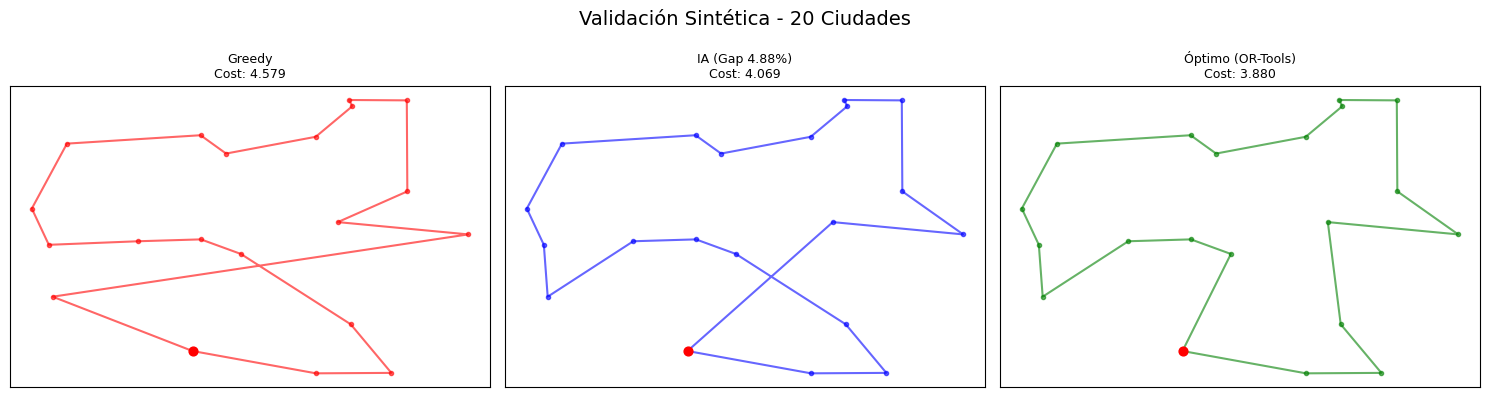


🔹 Generando 5000 mapas de 50 ciudades...
   🐢 Calculando Greedy...
   🧠 Calculando IA (Beam=1)...
------------------------------
   📊 RESULTADOS (N=50):
   🔴 Gap Greedy: 19.73%
   🔵 Gap IA:     1.51%
   ✨ Mejora:     18.22 pp
------------------------------


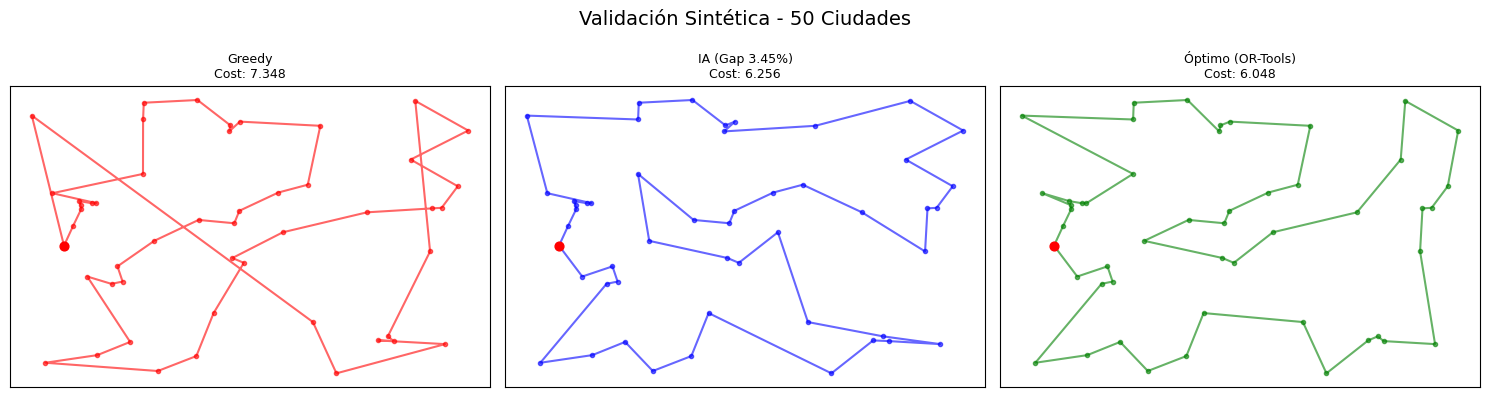


🔹 Generando 2500 mapas de 100 ciudades...
   🐢 Calculando Greedy...
   🧠 Calculando IA (Beam=1)...
------------------------------
   📊 RESULTADOS (N=100):
   🔴 Gap Greedy: 20.35%
   🔵 Gap IA:     4.64%
   ✨ Mejora:     15.71 pp
------------------------------


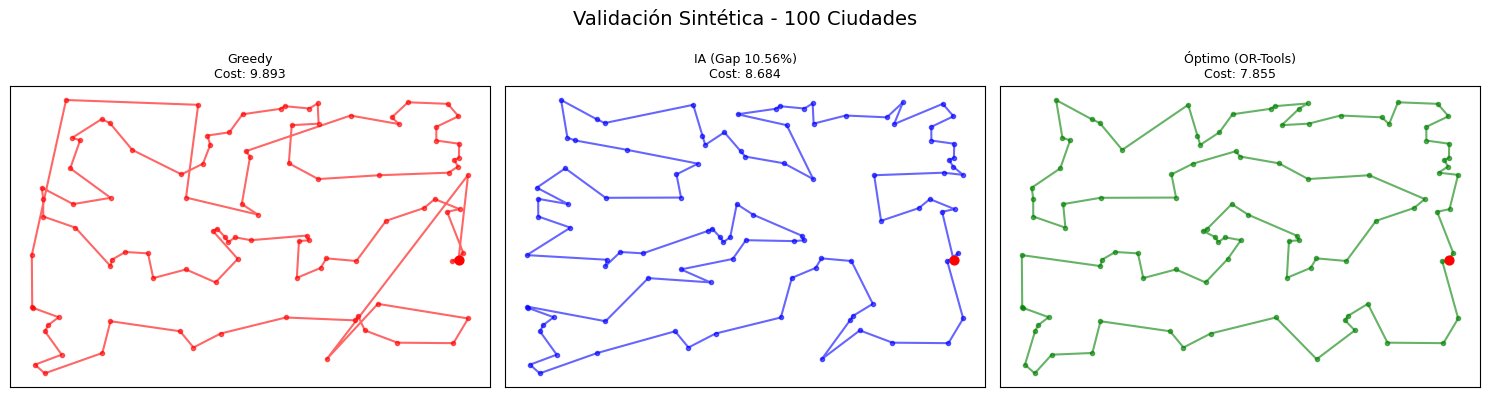

In [7]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE PRUEBA ---
TEST_CONFIGS = [
    {"num_cities": 20,  "num_samples": 10000},  # Prueba rápida Easy
    {"num_cities": 50,  "num_samples": 5000},   # Prueba rápida Medium
    {"num_cities": 100, "num_samples": 2500}    # Prueba rápida Hard
]
BEAM_WIDTH_VAL = 1

# ---------------------------------------------------------
# 1. GENERADOR ON-THE-FLY
# ---------------------------------------------------------
def generate_batch_and_solve(num_cities, batch_size):
    """
    Genera un batch de mapas y resuelve con OR-Tools para tener el Ground Truth.
    """
    X_batch = []
    Y_batch = []

    # Generar mapas
    locs = np.random.rand(batch_size, num_cities, 2)

    # Resolver cada uno con OR-Tools (Lento pero seguro)
    for i in range(batch_size):
        instance = TSP_Instance(locs[i])
        tour = solve_ortools(instance) # Devuelve lista de índices [0, 5, 2...]

        # Ajuste: OR-Tools a veces devuelve el ciclo cerrado o abierto.
        # Nos aseguramos de tener N índices únicos (sin repetir el cierre)
        if len(tour) > num_cities:
            tour = tour[:num_cities]

        X_batch.append(locs[i])
        Y_batch.append(tour)

    return np.array(X_batch), np.array(Y_batch)

# ---------------------------------------------------------
# 2. VALIDACIÓN SINTÉTICA
# ---------------------------------------------------------
def run_synthetic_validation():
    # 1. Cargar Modelo (Asegúrate de que coincida con tu entrenamiento)
    model_path = "models/tsp_transformer_ep3.pth"
    if not os.path.exists(model_path): model_path = "models/tsp_transformer.pth"

    if not os.path.exists(model_path):
        print("⚠️ No encuentro el modelo para validar.")
        return

    print(f"🧠 Cargando modelo: {model_path}")
    model = TSPTransformer(input_dim=2, embed_dim=128, num_heads=4, num_encoder_layers=2).to(DEVICE)
    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    except:
        print("❌ Error de arquitectura al cargar pesos.")
        return
    model.eval()

    print(f"🚀 INICIANDO VALIDACIÓN SINTÉTICA (OR-TOOLS vs IA)")

    for cfg in TEST_CONFIGS:
        N = cfg['num_cities']
        S = cfg['num_samples']

        print(f"\n{'='*60}")
        print(f"🔹 Generando {S} mapas de {N} ciudades...")

        # Generar datos reales ahora mismo
        X_np, Y_np = generate_batch_and_solve(N, S)

        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(DEVICE)

        # --- A. GREEDY ---
        print("   🐢 Calculando Greedy...")
        tours_greedy = solve_greedy_batch(X_tensor) # Función definida en bloque anterior
        cost_greedy = calc_dist(X_tensor, tours_greedy)

        # --- B. TU IA (Beam Search) ---
        print(f"   🧠 Calculando IA (Beam={BEAM_WIDTH_VAL})...")
        # Procesamos en un solo batch gigante si cabe, o en trozos
        tours_ai = []
        # Pequeño loop por si S es muy grande
        eval_bs = 32
        for i in range(0, S, eval_bs):
            batch = X_tensor[i : i+eval_bs]
            tours_ai.append(solve_beam_batch(model, batch, beam_width=BEAM_WIDTH_VAL))
        tours_ai = torch.cat(tours_ai)
        cost_ai = calc_dist(X_tensor, tours_ai)

        # --- C. ÓPTIMO (OR-TOOLS) ---
        Y_tensor = torch.tensor(Y_np, dtype=torch.long).to(DEVICE)
        cost_opt = calc_dist(X_tensor, Y_tensor)

        # --- MÉTRICAS ---
        gap_ai = ((cost_ai - cost_opt) / cost_opt) * 100
        gap_greedy = ((cost_greedy - cost_opt) / cost_opt) * 100

        print("-" * 30)
        print(f"   📊 RESULTADOS (N={N}):")
        print(f"   🔴 Gap Greedy: {gap_greedy.mean().item():.2f}%")
        print(f"   🔵 Gap IA:     {gap_ai.mean().item():.2f}%")
        print(f"   ✨ Mejora:     {gap_greedy.mean().item() - gap_ai.mean().item():.2f} pp")
        print("-" * 30)

        # --- PLOT ---
        idx = 0
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        plot_case(axs[0], X_np[idx], tours_greedy[idx].cpu(), cost_greedy[idx].item(), "Greedy", "red")
        plot_case(axs[1], X_np[idx], tours_ai[idx].cpu(), cost_ai[idx].item(), f"IA (Gap {gap_ai[idx].item():.2f}%)", "blue")
        plot_case(axs[2], X_np[idx], Y_np[idx], cost_opt[idx].item(), "Óptimo (OR-Tools)", "green")
        plt.suptitle(f"Validación Sintética - {N} Ciudades", fontsize=14)
        plt.tight_layout()
        plt.show()

# Ejecutar
run_synthetic_validation()

# 7. VALIDACIÓN EXTERNA (GITHUB BENCHMARKS)


📦 Iniciando descarga y carga de datos desde GitHub...
   🔹 Procesando Fase: EASY...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Procesando Fase: MEDIUM...
      ✅ 10 archivos cargados. Total casos: 1000
   🔹 Procesando Fase: HARD...
      ✅ 5 archivos cargados. Total casos: 500

✨ Datos listos en memoria.
🧠 Cargando modelo desde models/tsp_transformer_ep3.pth...
✅ Pesos cargados correctamente.
🚀 INICIANDO EVALUACIÓN (Beam Width=1)

🔹 FASE: EASY
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


------------------------------
   📊 RESULTADOS (1000 casos):
   🔴 Gap Greedy: 17.26%
   🔵 Gap IA:     2.05%
   ✨ Mejora:     15.22 puntos porcentuales
------------------------------


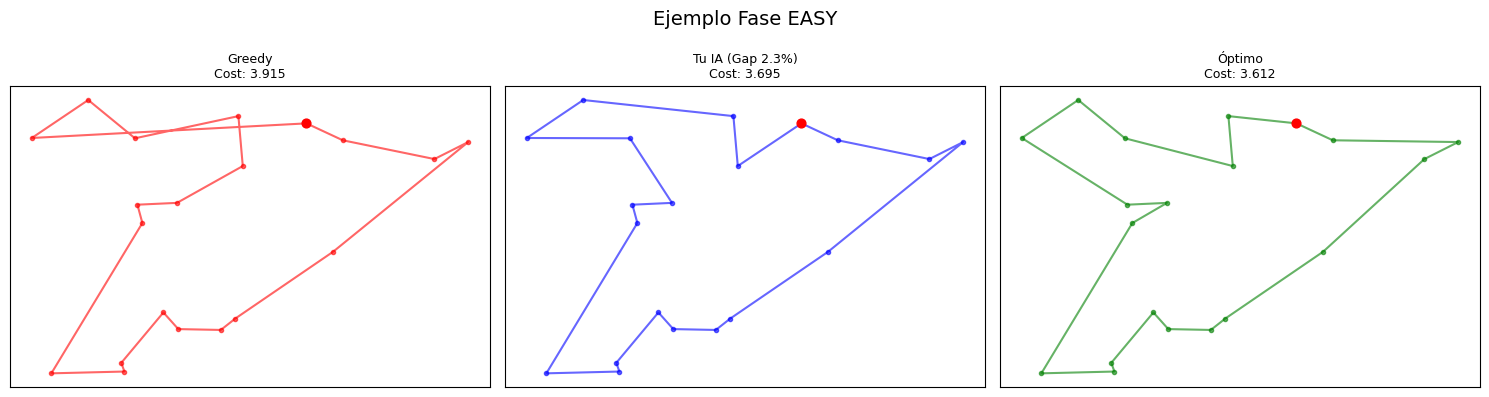


🔹 FASE: MEDIUM
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 8/8 [00:01<00:00,  7.45it/s]


------------------------------
   📊 RESULTADOS (1000 casos):
   🔴 Gap Greedy: 21.27%
   🔵 Gap IA:     2.57%
   ✨ Mejora:     18.71 puntos porcentuales
------------------------------


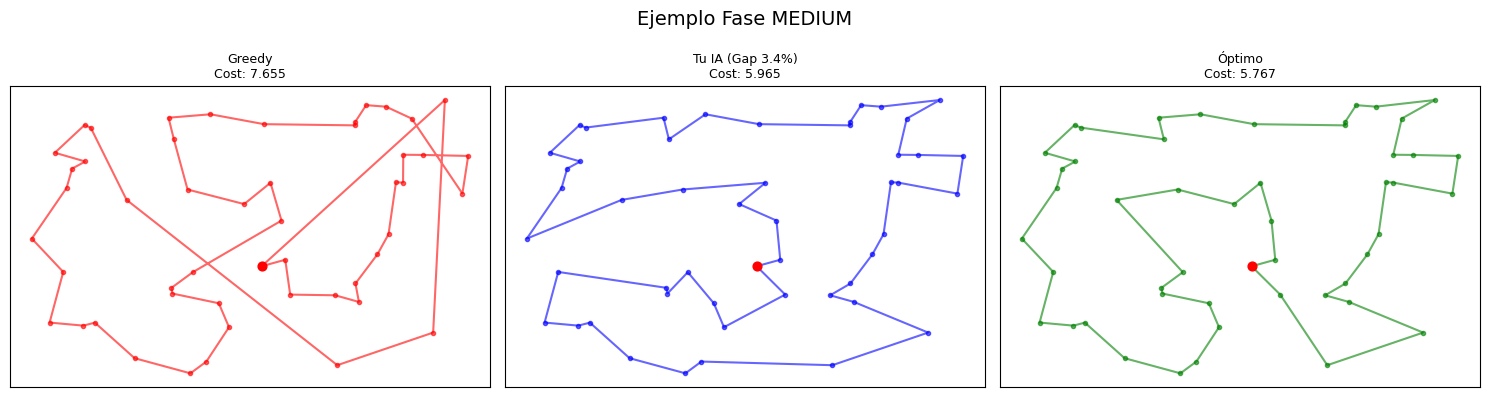


🔹 FASE: HARD
   🐢 Ejecutando Greedy...
   🧠 Ejecutando IA (Beam Search)...


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

------------------------------
   📊 RESULTADOS (500 casos):
   🔴 Gap Greedy: 21.17%
   🔵 Gap IA:     5.44%
   ✨ Mejora:     15.73 puntos porcentuales
------------------------------


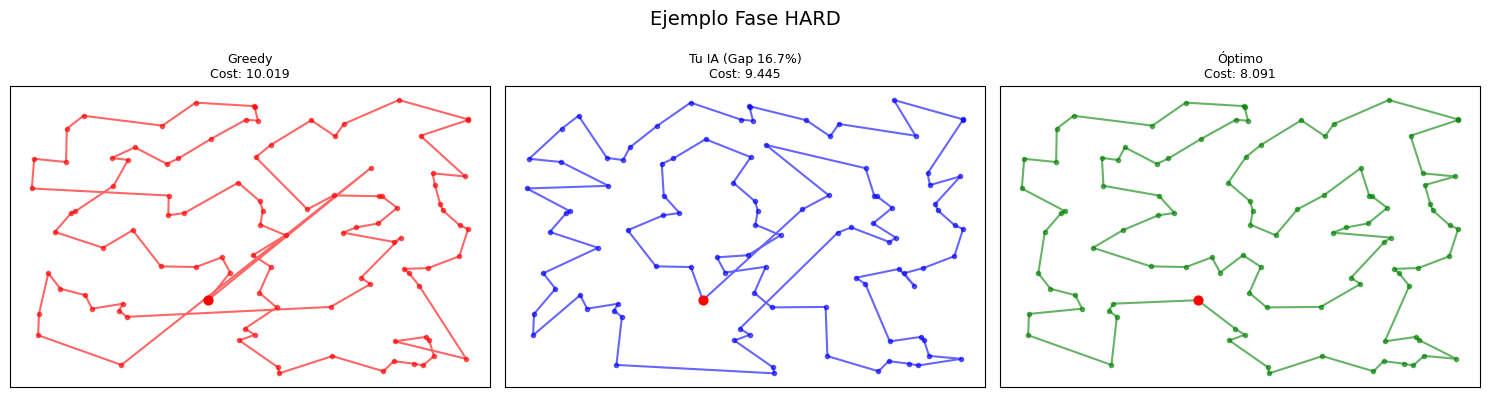

In [6]:
import requests
import os
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
REPO_USER = "felipe-astudillo-s"
REPO_NAME = "TransformerTSP"
BRANCH = "main"
VAL_FOLDERS = {
    "EASY":   {"gh_path": "Data/Validation/Easy",   "prefix": "tsp_easy"},   # 20 ciudades
    "MEDIUM": {"gh_path": "Data/Validation/Medium", "prefix": "tsp_medium"}, # 50 ciudades
    "HARD":   {"gh_path": "Data/Validation/Hard",   "prefix": "tsp_hard"}    # 100 ciudades
}
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BEAM_WIDTH = 1  # Greedy
BATCH_SIZE = 128

# ---------------------------------------------------------
# 1. GESTIÓN DE DATOS (DESCARGA Y CARGA)
# ---------------------------------------------------------
GLOBAL_DATA = {}

def download_and_load_github_data():
    print("📦 Iniciando descarga y carga de datos desde GitHub...")

    for phase, cfg in VAL_FOLDERS.items():
        print(f"   🔹 Procesando Fase: {phase}...")
        local_dir = f"val_data/{phase}"
        os.makedirs(local_dir, exist_ok=True)

        # A. Listar archivos via API
        api_url = f"https://api.github.com/repos/{REPO_USER}/{REPO_NAME}/contents/{cfg['gh_path']}?ref={BRANCH}"
        try:
            resp = requests.get(api_url)
            if resp.status_code != 200:
                print(f"      ⚠️ Error API GitHub: {resp.status_code}"); continue
            files = resp.json()
        except: print("      ⚠️ Error de conexión."); continue

        all_points, all_sols = [], []
        count = 0

        # B. Descargar y Procesar .npz
        for item in files:
            if item['name'].endswith('.npz') and item['name'].startswith(cfg['prefix']):
                local_path = os.path.join(local_dir, item['name'])

                # Descargar si no existe
                if not os.path.exists(local_path):
                    with open(local_path, 'wb') as f:
                        f.write(requests.get(item['download_url']).content)

                # Cargar
                try:
                    data = np.load(local_path, allow_pickle=True)
                    pts = data['points'] # [B, N, 2]
                    sols = data['solutions'] # [B, N]

                    # Normalizar formato de soluciones
                    if sols.dtype == np.object_:
                        sols = np.vstack(sols).astype(np.int64)
                    else:
                        sols = sols.astype(np.int64)

                    all_points.append(pts)
                    all_sols.append(sols)
                    count += 1
                except Exception as e:
                    print(f"      ❌ Error leyendo {item['name']}: {e}")

        if all_points:
            # Concatenar todo
            X_concat = np.concatenate(all_points)
            Y_concat = np.concatenate(all_sols)

            GLOBAL_DATA[phase] = {'X': X_concat, 'Y': Y_concat}
            print(f"      ✅ {count} archivos cargados. Total casos: {len(X_concat)}")
        else:
            print("      ⚠️ No se encontraron datos válidos.")

    print("\n✨ Datos listos en memoria.")

# ---------------------------------------------------------
# 2. SOLVERS (IA & GREEDY)
# ---------------------------------------------------------

def solve_greedy_batch(x):
    """Greedy Nearest Neighbor vectorizado"""
    B, N, _ = x.shape
    device = x.device
    dists = torch.cdist(x, x, p=2)
    dists.diagonal(dim1=-2, dim2=-1).fill_(float('inf'))

    current_city = torch.zeros(B, dtype=torch.long, device=device)
    tour = [current_city]
    visited_mask = torch.zeros(B, N, dtype=torch.bool, device=device)
    batch_indices = torch.arange(B, device=device)
    visited_mask[batch_indices, current_city] = True

    for _ in range(N - 1):
        d_curr = dists[batch_indices, current_city]
        d_curr[visited_mask] = float('inf')
        next_city = d_curr.argmin(dim=1)
        current_city = next_city
        visited_mask[batch_indices, current_city] = True
        tour.append(current_city)

    return torch.stack(tour, dim=1)

def solve_beam_batch(model, x, beam_width=3):
    """Beam Search simple para el modelo"""
    model.eval()
    B, N, _ = x.shape

    # Encoder
    with torch.no_grad():
        memory = model.encode(x) # [B, N, E]

    # Expandir para Beam
    # memory: [B*K, N, E]
    memory = memory.repeat_interleave(beam_width, dim=0)
    x_expanded = x.repeat_interleave(beam_width, dim=0)

    # Estado inicial
    tours = torch.zeros((B * beam_width, N), dtype=torch.long).to(DEVICE)
    visited = torch.full((B * beam_width, N), -1, dtype=torch.long).to(DEVICE)
    visited[:, 0] = 0

    # Scores acumulados (Log Prob)
    beam_scores = torch.zeros((B, beam_width), device=DEVICE)
    beam_scores[:, 1:] = float('-inf') # Solo el primer beam es válido al inicio
    beam_scores = beam_scores.view(-1) # [B*K]

    batch_base_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE).unsqueeze(1)

    with torch.no_grad():
        for t in range(N - 1):
            # Decoder Step
            logits = model.decode(memory, x_expanded, visited) # [B*K, N]
            log_probs = F.log_softmax(logits, dim=1)

            # Sumar score acumulado anterior
            # [B*K, N] = [B*K, 1] + [B*K, N]
            next_scores = beam_scores.unsqueeze(1) + log_probs

            # Reshape para topk por batch: [B, K*N]
            next_scores = next_scores.view(B, beam_width * N)

            # Top-K mejores globalmente para cada batch
            best_scores, best_indices = torch.topk(next_scores, beam_width, dim=1)

            # Desglosar índices
            prev_beam_idx = best_indices // N  # De qué beam venía (0..K-1)
            next_city_idx = best_indices % N   # A qué ciudad va (0..N-1)

            # Índices planos para seleccionar del tensor grande
            flat_prev_idx = (batch_base_indices + prev_beam_idx).view(-1)

            # Actualizar estado
            beam_scores = best_scores.view(-1)
            tours = tours[flat_prev_idx]
            visited = visited[flat_prev_idx]

            # Añadir nueva ciudad
            next_cities_flat = next_city_idx.view(-1)
            tours[:, t+1] = next_cities_flat
            visited[:, t+1] = next_cities_flat

    # Seleccionar el mejor beam (índice 0, ya que topk ordena)
    best_indices = torch.arange(0, B * beam_width, beam_width, device=DEVICE)
    return tours[best_indices]

# ---------------------------------------------------------
# 3. HELPERS Y PLOTTING
# ---------------------------------------------------------

def calc_dist(points, tour_idx):
    """Calcula distancia total del tour (batch)"""
    if points.device != tour_idx.device: tour_idx = tour_idx.to(points.device)
    # Gather ordena los puntos según el tour
    ordered = points.gather(1, tour_idx.unsqueeze(-1).expand(-1, -1, 2))
    # Distancia entre puntos consecutivos + vuelta al inicio
    diff = ordered - torch.roll(ordered, -1, dims=1)
    return torch.norm(diff, dim=2).sum(dim=1)

def plot_case(ax, points, tour, cost, title, color):
    # Tour cerrado para dibujar
    tour = list(tour) + [tour[0]]
    path = points[tour]
    ax.plot(path[:,0], path[:,1], 'o-', color=color, alpha=0.6, markersize=3)
    ax.scatter(path[0,0], path[0,1], c='red', s=40, zorder=10) # Inicio
    ax.set_title(f"{title}\nCost: {cost:.3f}", fontsize=9)
    ax.set_xticks([]); ax.set_yticks([])

# ---------------------------------------------------------
# 4. EJECUCIÓN PRINCIPAL
# ---------------------------------------------------------

def run_external_validation():
    # 1. Cargar Datos
    if not GLOBAL_DATA:
        download_and_load_github_data()

    # 2. Cargar Modelo
    model_path = "models/tsp_transformer_ep3.pth" # Asegúrate que este sea el nombre correcto
    if not os.path.exists(model_path):
        print(f"⚠️ No encuentro el modelo en {model_path}")
        # Intentamos con el nombre alternativo por si acaso
        model_path = "models/tsp_transformer.pth"
        if not os.path.exists(model_path): return

    print(f"🧠 Cargando modelo desde {model_path}...")

    # --- CORRECCIÓN AQUÍ ---
    # Debemos usar num_encoder_layers=2 y num_heads=4 para coincidir con tu entrenamiento
    model = TSPTransformer(
        input_dim=2,
        embed_dim=128,
        num_heads=4,          # Antes tenías 8
        num_encoder_layers=2, # Antes tenías 3 (Esto causaba el error)
        num_glimpses=2,       # Aseguramos que coincida también
        dropout_rate=0.1
    ).to(DEVICE)
    # -----------------------

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("✅ Pesos cargados correctamente.")
    except Exception as e:
        print(f"❌ Error crítico cargando pesos: {e}")
        print("💡 Consejo: Verifica que 'embed_dim', 'num_heads' y 'num_layers' sean IDÉNTICOS al entrenamiento.")
        return

    model.eval()

    print(f"🚀 INICIANDO EVALUACIÓN (Beam Width={BEAM_WIDTH})")

    for phase, data in GLOBAL_DATA.items():
        print(f"\n{'='*60}")
        print(f"🔹 FASE: {phase}")

        X_np = data['X']
        Y_np = data['Y']

        n_samples = min(1000, len(X_np))
        X_eval = X_np[:n_samples]
        Y_eval = Y_np[:n_samples]

        X_tensor = torch.tensor(X_eval, dtype=torch.float32).to(DEVICE)

        # --- A. GREEDY BASELINE ---
        print("   🐢 Ejecutando Greedy...")
        tours_greedy = []
        for i in range(0, n_samples, BATCH_SIZE):
            batch = X_tensor[i:i+BATCH_SIZE]
            tours_greedy.append(solve_greedy_batch(batch))
        tours_greedy = torch.cat(tours_greedy)
        cost_greedy = calc_dist(X_tensor, tours_greedy)

        # --- B. TU MODELO (IA) ---
        print("   🧠 Ejecutando IA (Beam Search)...")
        tours_ai = []
        for i in tqdm(range(0, n_samples, BATCH_SIZE)):
            batch = X_tensor[i:i+BATCH_SIZE]
            tours_ai.append(solve_beam_batch(model, batch, beam_width=BEAM_WIDTH))
        tours_ai = torch.cat(tours_ai)
        cost_ai = calc_dist(X_tensor, tours_ai)

        # --- C. ÓPTIMO ---
        Y_tensor = torch.tensor(Y_eval, dtype=torch.long).to(DEVICE)
        Y_clean = Y_tensor.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_tensor, Y_clean)

        # --- MÉTRICAS ---
        # Evitar división por cero si el costo óptimo es 0 (caso trivial)
        mask = cost_opt > 0
        gap_ai = torch.zeros_like(cost_ai)
        gap_greedy = torch.zeros_like(cost_greedy)

        gap_ai[mask] = ((cost_ai[mask] - cost_opt[mask]) / cost_opt[mask]) * 100
        gap_greedy[mask] = ((cost_greedy[mask] - cost_opt[mask]) / cost_opt[mask]) * 100

        avg_gap_ai = gap_ai.mean().item()
        avg_gap_gr = gap_greedy.mean().item()

        improvement = avg_gap_gr - avg_gap_ai

        print("-" * 30)
        print(f"   📊 RESULTADOS ({n_samples} casos):")
        print(f"   🔴 Gap Greedy: {avg_gap_gr:.2f}%")
        print(f"   🔵 Gap IA:     {avg_gap_ai:.2f}%")
        print(f"   ✨ Mejora:     {improvement:.2f} puntos porcentuales")
        print("-" * 30)

        # --- VISUALIZACIÓN ---
        idx = 0
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        plot_case(axs[0], X_eval[idx], tours_greedy[idx].cpu(), cost_greedy[idx].item(), "Greedy", "red")
        plot_case(axs[1], X_eval[idx], tours_ai[idx].cpu(), cost_ai[idx].item(), f"Tu IA (Gap {gap_ai[idx].item():.1f}%)", "blue")
        plot_case(axs[2], X_eval[idx], Y_eval[idx], cost_opt[idx].item(), "Óptimo", "green")
        plt.suptitle(f"Ejemplo Fase {phase}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Ejecutar el bloque completo
run_external_validation()

# VALIDACIÓN PRO: TEST-TIME AUGMENTATION (TTA x8)

In [ ]:

def augment_batch_8x(x):
    """Genera 8 variaciones isométricas del batch de mapas."""
    # x: [B, N, 2]
    # 0. Original
    x0 = x.clone()
    # 1. Rot 90
    x1 = torch.stack([x[:,:,1], 1-x[:,:,0]], dim=2)
    # 2. Rot 180
    x2 = torch.stack([1-x[:,:,0], 1-x[:,:,1]], dim=2)
    # 3. Rot 270
    x3 = torch.stack([1-x[:,:,1], x[:,:,0]], dim=2)
    # 4. Flip X
    x4 = torch.stack([1-x[:,:,0], x[:,:,1]], dim=2)
    # 5. Flip X + Rot 90
    x5 = torch.stack([x[:,:,1], x[:,:,0]], dim=2) # Transpose
    # 6. Flip X + Rot 180
    x6 = torch.stack([x[:,:,0], 1-x[:,:,1]], dim=2)
    # 7. Flip X + Rot 270
    x7 = torch.stack([1-x[:,:,1], 1-x[:,:,0]], dim=2)

    # Retorna shape [B*8, N, 2]
    return torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], dim=0)

def solve_tta(model, x_batch):
    """Resuelve usando TTA x8 y devuelve la mejor distancia por instancia."""
    B, N, _ = x_batch.shape

    # 1. Expandir el batch x8 (Augmentation)
    x_aug = augment_batch_8x(x_batch) # [B*8, N, 2]

    # 2. Resolver todo el batch aumentado
    with torch.no_grad():
        # Encode una vez para todo el batch aumentado
        memory = model.encode(x_aug)

        # Greedy Decoding manual
        tours = torch.zeros((B*8, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B*8, N), -1, dtype=torch.long).to(DEVICE)
        visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_aug, visited)
            next_city = logits.argmax(dim=1)
            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # 3. Calcular distancias de las 8 versiones
    dists = calc_dist(x_aug, tours) # [B*8]

    # 4. Volver a agrupar [B, 8] y tomar el mínimo
    dists = dists.view(8, B).transpose(0, 1) # [B, 8]
    best_dists, _ = dists.min(dim=1) # [B]

    return best_dists

def run_tta_validation():
    print(f"🚀 INICIANDO VALIDACIÓN TTA (x8) - La prueba definitiva")

    # 1. Cargar Datos si no están
    if not GLOBAL_DATA: download_and_load_github_data()

    # 2. CARGAR MODELO (Robust Load)
    model_path = "models/tsp_transformer_ep3.pth"
    if not os.path.exists(model_path):
        model_path = "models/tsp_transformer.pth" # Intento alternativo

    if not os.path.exists(model_path):
        print(f"❌ Error: No encuentro el modelo en 'models/'.")
        return

    print(f"🧠 Cargando modelo desde: {model_path}")

    # Instanciar con la arquitectura CORRECTA (2 capas, 4 heads)
    model = TSPTransformer(
        input_dim=2,
        embed_dim=128,
        num_heads=4,          # Configuración del entrenamiento
        num_encoder_layers=2, # Configuración del entrenamiento
        num_glimpses=2,
        dropout_rate=0.1
    ).to(DEVICE)

    try:
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
        print("✅ Pesos cargados correctamente.")
    except Exception as e:
        print(f"❌ Error cargando pesos: {e}")
        return

    model.eval()

    # 3. BUCLE DE VALIDACIÓN
    for phase, data in GLOBAL_DATA.items():
        X_np = data['X']
        Y_np = data['Y']

        # Usamos menos muestras para TTA porque es 8 veces más pesado
        n_samples = min(200, len(X_np))
        X_eval = torch.tensor(X_np[:n_samples], dtype=torch.float32).to(DEVICE)
        Y_eval = torch.tensor(Y_np[:n_samples], dtype=torch.long).to(DEVICE)

        # Calcular óptimo
        Y_clean = Y_eval.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_eval, Y_clean)

        # Calcular IA con TTA
        cost_ai_tta = []
        batch_size = 16 # Batch más pequeño porque x8 ocupa memoria

        for i in tqdm(range(0, n_samples, batch_size), desc=f"Fase {phase}"):
            batch = X_eval[i:i+batch_size]
            dists = solve_tta(model, batch)
            cost_ai_tta.append(dists)

        cost_ai_tta = torch.cat(cost_ai_tta)

        # Gap
        # Evitar división por cero si cost_opt es 0 (caso trivial 1 ciudad)
        mask = cost_opt > 0
        gap = torch.zeros_like(cost_ai_tta)
        gap[mask] = ((cost_ai_tta[mask] - cost_opt[mask]) / cost_opt[mask]) * 100

        avg_gap = gap.mean().item()

        print(f"📊 {phase} (TTA x8): Gap Promedio = {avg_gap:.2f}%")

# ¡Pruébalo!
run_tta_validation()

🚀 INICIANDO VALIDACIÓN TTA (x8) - La prueba definitiva
🧠 Cargando modelo desde: models/tsp_transformer_ep3.pth
✅ Pesos cargados correctamente.


Fase EASY: 100%|██████████| 13/13 [00:00<00:00, 18.69it/s]


📊 EASY (TTA x8): Gap Promedio = 0.71%


Fase MEDIUM: 100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


📊 MEDIUM (TTA x8): Gap Promedio = 0.53%


Fase HARD: 100%|██████████| 13/13 [00:03<00:00,  3.86it/s]

📊 HARD (TTA x8): Gap Promedio = 2.58%


#Sampling

In [ ]:
# ==========================================
# VALIDACIÓN PRO: MULTI-SAMPLE (x128)
# ==========================================

def solve_sampling(model, x_batch, num_samples=1000, temperature=1.0):
    """
    Genera múltiples rutas usando muestreo probabilístico y retorna la mejor.
    x_batch: [B, N, 2]
    """
    model.eval()
    B, N, _ = x_batch.shape

    # 1. Expandir el batch para procesar todas las muestras en paralelo
    # [B*num_samples, N, 2]
    x_expanded = x_batch.repeat_interleave(num_samples, dim=0)

    with torch.no_grad():
        memory = model.encode(x_expanded)

        tours = torch.zeros((B * num_samples, N), dtype=torch.long).to(DEVICE)
        visited = torch.full((B * num_samples, N), -1, dtype=torch.long).to(DEVICE)

        # Empezamos siempre en la ciudad 0
        tours[:, 0] = 0
        visited[:, 0] = 0

        for t in range(N - 1):
            logits = model.decode(memory, x_expanded, visited)

            # Aplicar temperatura para controlar la exploración
            # temp > 1: más aleatorio | temp < 1: más conservador
            probs = F.softmax(logits / temperature, dim=1)

            # Muestrear la siguiente ciudad
            next_city = torch.multinomial(probs, num_samples=1).squeeze(1)

            tours[:, t+1] = next_city
            visited[:, t+1] = next_city

    # 2. Calcular distancias de todas las rutas generadas
    dists = calc_dist(x_expanded, tours) # [B * num_samples]

    # 3. Agrupar por instancia original y buscar el mínimo
    dists = dists.view(B, num_samples)
    best_dists, _ = dists.min(dim=1)

    return best_dists

def run_sampling_validation():
    print(f"🚀 INICIANDO VALIDACIÓN POR SAMPLING (x128)")

    # Parámetros
    SAMPLES_PER_MAP = 500
    TEMP = 1.0 # Temperatura estándar

    if not GLOBAL_DATA: download_and_load_github_data()

    # Cargar Modelo (Asegúrate que la ruta sea la correcta)
    model_path = "models/tsp_transformer_ep3.pth"
    model = TSPTransformer(input_dim=2, embed_dim=128, num_heads=4, num_encoder_layers=2).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    for phase, data in GLOBAL_DATA.items():
        X_np = data['X']
        Y_np = data['Y']

        n_samples = min(100, len(X_np)) # Reducimos N de test porque Sampling es pesado
        X_eval = torch.tensor(X_np[:n_samples], dtype=torch.float32).to(DEVICE)
        Y_eval = torch.tensor(Y_np[:n_samples], dtype=torch.long).to(DEVICE)

        # Óptimo
        Y_clean = Y_eval.clone()
        Y_clean[Y_clean == -1] = 0
        cost_opt = calc_dist(X_eval, Y_clean)

        # IA con Sampling
        cost_ai_sampling = []
        batch_size = 4 # Batch pequeño porque B * 128 consume mucha VRAM

        for i in tqdm(range(0, n_samples, batch_size), desc=f"Sampling {phase}"):
            batch = X_eval[i:i+batch_size]
            best_dists = solve_sampling(model, batch, num_samples=SAMPLES_PER_MAP, temperature=TEMP)
            cost_ai_sampling.append(best_dists)

        cost_ai_sampling = torch.cat(cost_ai_sampling)

        # Gap
        mask = cost_opt > 0
        gap = ((cost_ai_sampling[mask] - cost_opt[mask]) / cost_opt[mask]) * 100
        print(f"📊 {phase} (Sampling x128): Gap Promedio = {gap.mean().item():.2f}%")

run_sampling_validation()

🚀 INICIANDO VALIDACIÓN POR SAMPLING (x128)


Sampling EASY: 100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


📊 EASY (Sampling x128): Gap Promedio = -0.00%


Sampling MEDIUM: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]


📊 MEDIUM (Sampling x128): Gap Promedio = -0.84%


Sampling HARD: 100%|██████████| 25/25 [00:57<00:00,  2.30s/it]

📊 HARD (Sampling x128): Gap Promedio = 4.20%
